# 1. Prepare necesary libraries

In [140]:
import pandas  as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime as dt 
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)

# 2. Loading data and cleaning

In [127]:
traffic = pd.read_csv('traffic_train.csv')

traffic.head()

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
0,2014-10-01 00:00:00,Clear,sky is clear,1,11.5,0.0,0.0,508
1,2014-10-01 01:00:00,Clear,sky is clear,1,10.3,0.0,0.0,323
2,2014-10-01 02:00:00,Clear,sky is clear,1,8.0,0.0,0.0,274
3,2014-10-01 03:00:00,Clear,sky is clear,1,7.9,0.0,0.0,372
4,2014-10-01 04:00:00,Clear,sky is clear,1,6.4,0.0,0.0,812


In [128]:
def dayFromDate(traffic):
    traffic['date_time'] = pd.to_datetime(traffic['date_time'])
    traffic['hour'] = traffic.date_time.dt.hour
    traffic['hour_interval'] = pd.cut(traffic.hour, bins = [-1,6,12,18,24], labels = ['0-6','6-12', '12-18', '18-24'])
    
    
    traffic['day'] = traffic.date_time.dt.day_of_week  
    
    traffic['month'] = traffic.date_time.dt.month

    traffic['tmp'] = range(0,len(traffic.hour))
    traffic['year'] = traffic.date_time.dt.year
    t1 = pd.get_dummies(traffic['month'])
    t1['tmp'] = range(0,len(traffic.month))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['hour_interval'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['hour'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['day'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp']).drop(columns = ['tmp'])
    return(traffic)

def ordinal_whether(traffic):
    traffic['ordinal_weather'] = np.where(traffic.weather_detailed.isin(['fog', 'freezing rain', 'heavy intensity rain','heavy snow','proximity thunderstorm',
                                 'proximity thunderstorm with drizzle', 'proximity thunderstorm with rain', 'sleet', 'squalls',
                                 'thunderstorm', 'thunderstorm with drizzle', 'thunderstorm with heavy rain', 'thunderstorm with light drizzle',
                                  'thunderstorm with light rain', 'thunderstorm with rain', 'very heavy rain']), 0, #fatalne
                                 np.where(traffic.weather_detailed.isin(['drizzle','haze', 'heavy intensity drizzle','light intensity drizzle','light intensity shower rain',
                                 'light rain', 'light rain and snow', 'light shower snow', 'light snow','mist', 'moderate rain', 'shower drizzle',
                                  'shower snow', 'smoke', 'snow', ]), 1, #kiepskie
                                 np.where(traffic.weather_detailed.isin(['broken clouds','few clouds', 'overcast clouds', 'proximity shower rain',
                                 ]), 2, #umiarkowane
                                 np.where(traffic.weather_detailed.isin(['scattered clouds', 'sky is clear', ]), 3, 99 )))) #dobre
    return (traffic)
    
def weather_dummies(traffic):
    t1 = pd.get_dummies(traffic['weather_general'])
    t1['tmp'] = range(0,len(traffic.weather_detailed))
    traffic['tmp'] = range(0,len(traffic.weather_detailed))
    traffic = pd.merge(traffic, t1, on = ['tmp'])
    traffic['Fog'] = traffic['Fog'] + traffic['Smoke']
    traffic['Rain'] = traffic['Rain'] + traffic['Squall']
    traffic = traffic.drop(columns = ['Smoke', 'Squall', 'tmp'])
    return(traffic)


def outliers_correction(traffic):

    traffic.temperature.loc[(traffic.temperature < -30)] = traffic.groupby(by = ['month']).mean().temperature[1]
    traffic.rain_mm.loc[traffic.rain_mm > 1000] = traffic.rain_mm.loc[traffic.rain_mm < 1000].max()
    return (traffic)



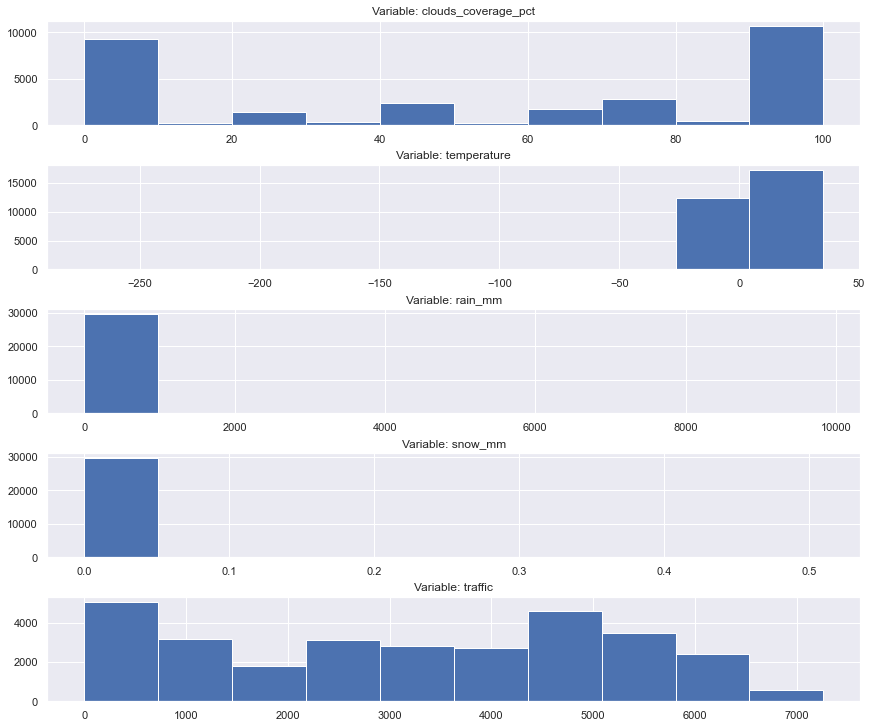

In [129]:
numericalVar = ['clouds_coverage_pct', 'temperature', 'rain_mm', 'snow_mm', 'traffic']
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(traffic[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')
    


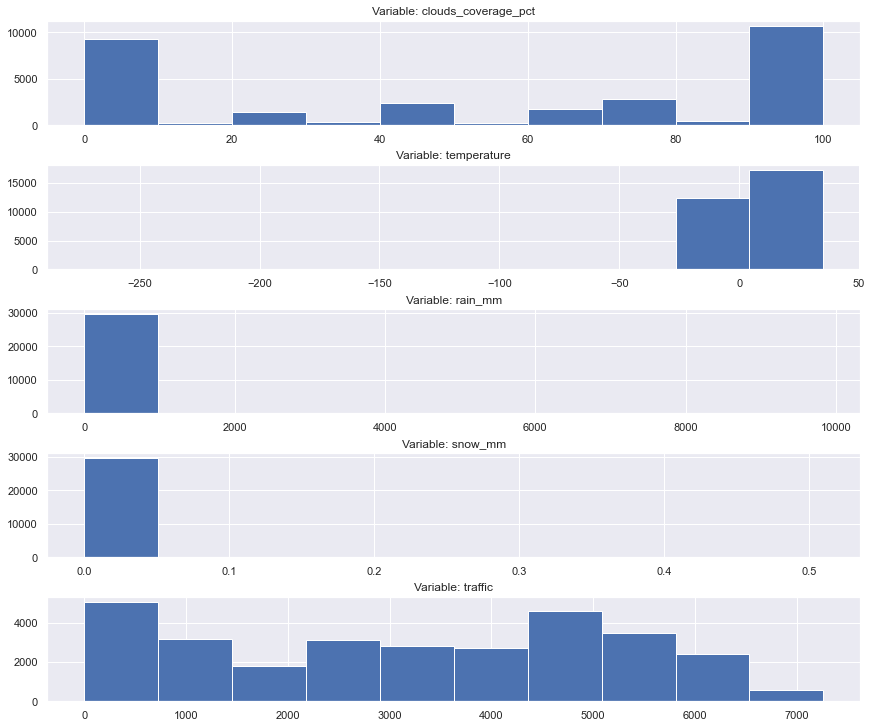

In [130]:
numericalVar = ['clouds_coverage_pct', 'temperature', 'rain_mm', 'snow_mm', 'traffic']
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(traffic[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')

# 3. Standarize data

In [131]:
# scale = StandardScaler()

# numericalData = traffic[numericalVar]

# scaledData = scale.fit_transform(numericalData)
# traffic[numericalVar] = pd.DataFrame(scaledData)

# traffic

# 4. Corrplot

In [132]:
corr = traffic.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
clouds_coverage_pct,nan,nan,nan,nan,nan
temperature,-0.15,nan,nan,nan,nan
rain_mm,0.01,0.01,nan,nan,nan
snow_mm,0.04,-0.02,-0.00,nan,nan
traffic,0.04,0.13,0.01,0.00,nan


In [133]:
traffic = pd.read_csv('traffic_train.csv')
functions = [dayFromDate(traffic), ordinal_whether(traffic), weather_dummies(traffic), outliers_correction(traffic)]

traffic = dayFromDate(traffic)
traffic = ordinal_whether(traffic)
traffic = weather_dummies(traffic)
traffic = outliers_correction(traffic)


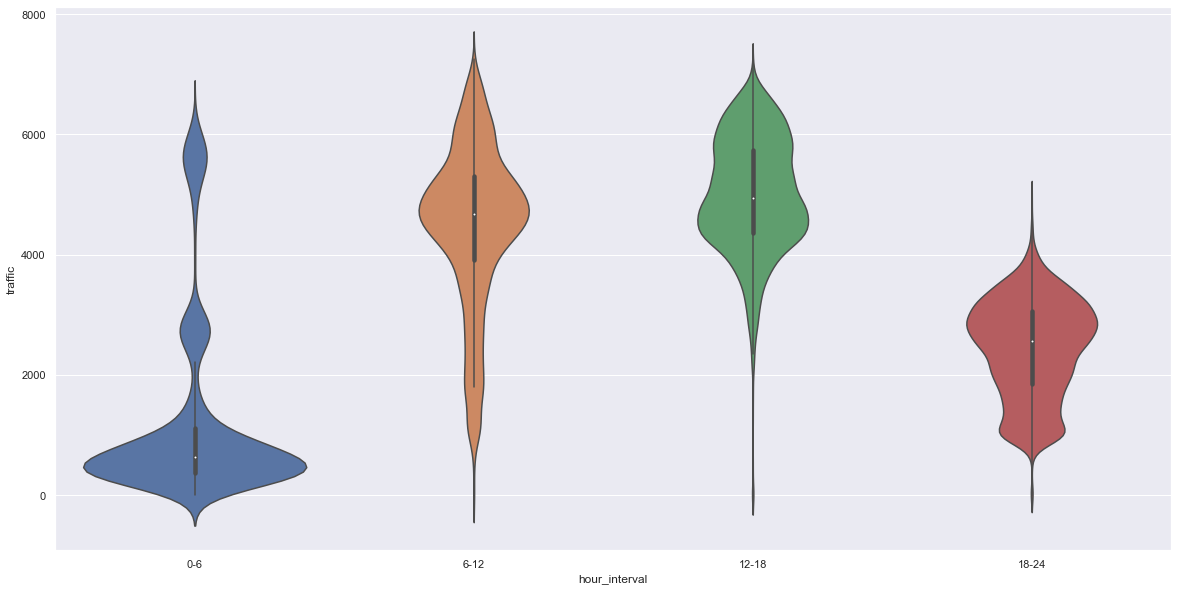

In [134]:
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.violinplot(x = traffic.hour_interval, y = traffic.traffic)

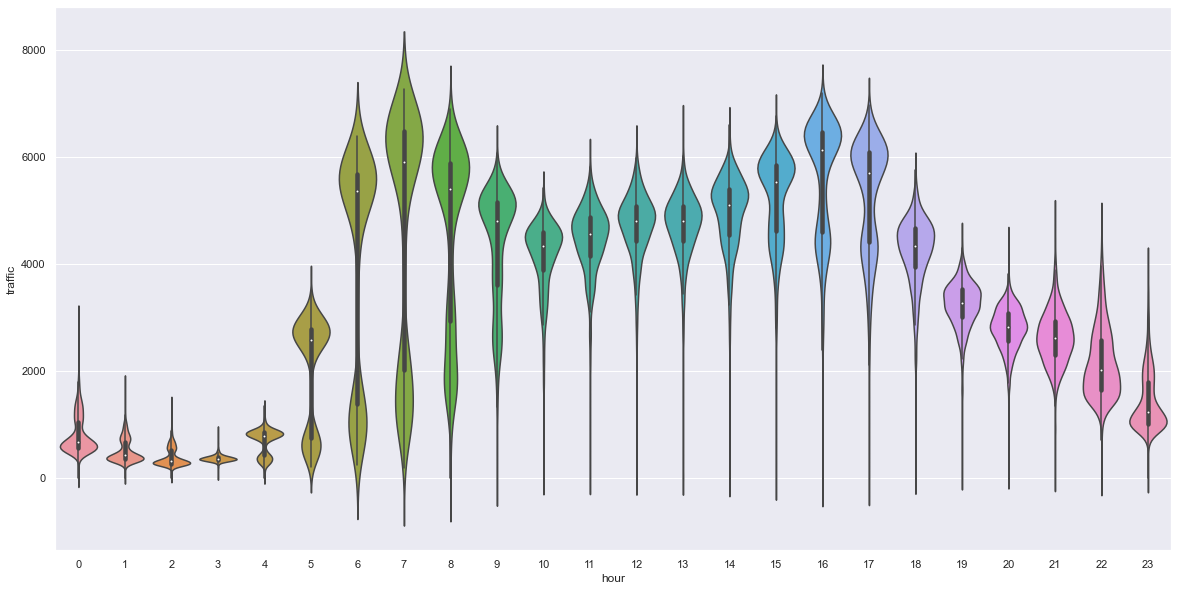

In [135]:
ax = sns.violinplot(x = traffic.hour, y = traffic.traffic, scale = "width")

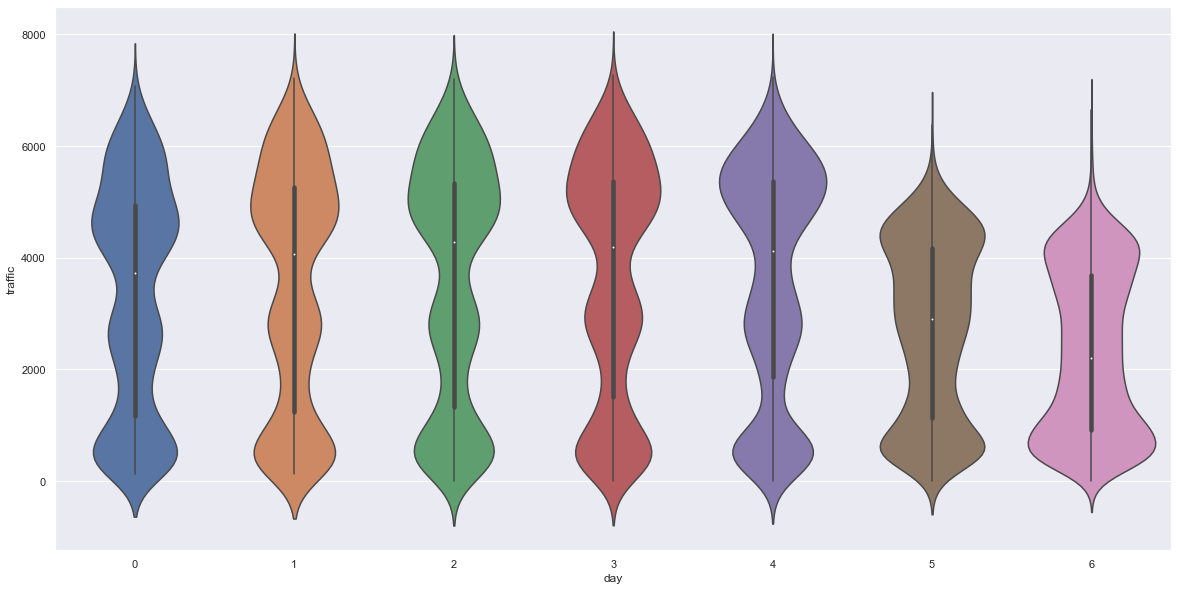

In [136]:
ax = sns.violinplot(x = traffic.day, y = traffic.traffic)

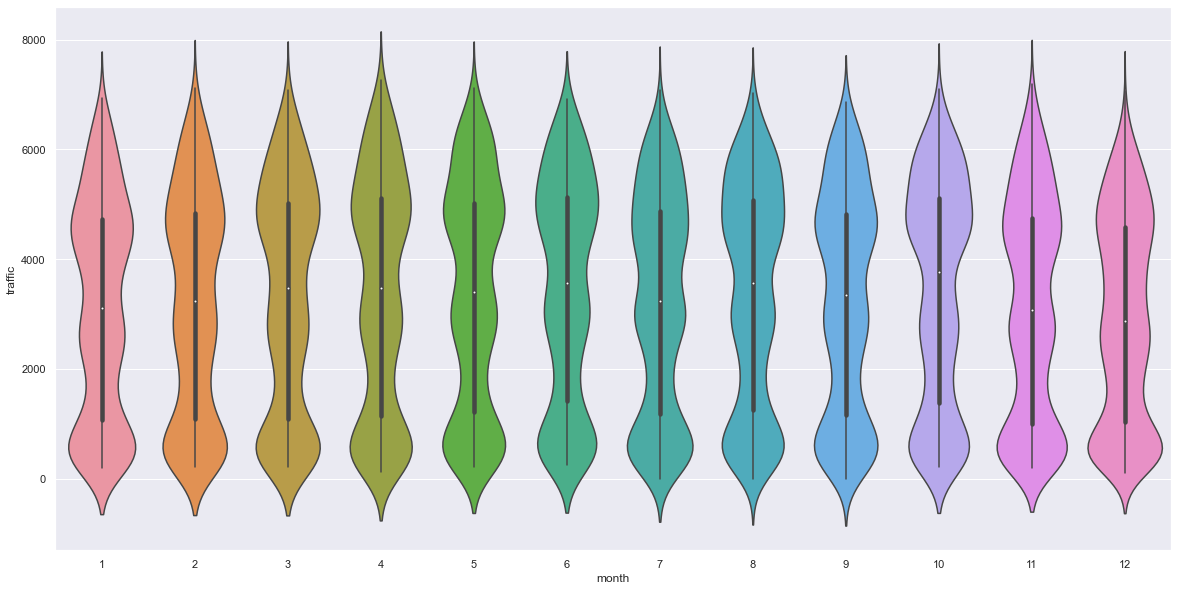

In [137]:
ax = sns.violinplot(x = traffic.month, y = traffic.traffic)

In [138]:
traffic = traffic[traffic['traffic'] != 0]
traffic = traffic[traffic['snow_mm'] == 0]
traffic = traffic[traffic['rain_mm'] == 0]
traffic = traffic.drop(columns = ['date_time', 'weather_general', 'weather_detailed', 'month', 'year', 'day', 'hour', 'rain_mm','snow_mm','hour_interval'])
#, '1_x',  '0-6','1_y','0_y'


x_train = traffic.drop(columns = ['traffic'])
y_train = traffic['traffic']

print(traffic.columns)
traffic.head()

Index(['clouds_coverage_pct',         'temperature',             'traffic',
           'ordinal_weather',                 '1_x',                 '2_x',
                       '3_x',                 '4_x',                 '5_x',
                       '6_x',                 '7_x',                 '8_x',
                       '9_x',                '10_x',                '11_x',
                      '12_x',                 '0-6',                '6-12',
                     '12-18',               '18-24',                 '0_x',
                       '1_y',                 '2_y',                 '3_y',
                       '4_y',                 '5_y',                 '6_y',
                       '7_y',                 '8_y',                 '9_y',
                      '10_y',                '11_y',                '12_y',
                          13,                    14,                    15,
                          16,                    17,                    18,
            

,clouds_coverage_pct,temperature,traffic,ordinal_weather,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,0-6,6-12,12-18,18-24,0_x,1_y,2_y,3_y,4_y,...,15,16,17,18,19,20,21,22,23,0_y,1,2,3,4,5,6,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Snow,Thunderstorm
0,1,11.5,508,3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,10.3,323,3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,8.0,274,3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,7.9,372,3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,6.4,812,3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [41]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(x_train, y_train)

y_pred = lin_reg.predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, y_pred) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, y_pred)}')
print(r2_score(y_train, y_pred))
print(y_pred)
print(y_train)


MAPE: 78.8284%
MAE: 597.8981285113666
0.8302986374865541
[1240.  984.  828. ... 1240. 1180. 1244.]
0         508
1         323
2         274
3         372
4         812
         ... 
29696    1228
29697    1218
29698     830
29699     828
29700     824
Name: traffic, Length: 26877, dtype: int64


In [ ]:
#
# from sklearn.tree import DecisionTreeRegressor

# tree_reg = DecisionTreeRegressor(random_state=42)
# tree_reg.fit(x_train, y_train)
# y_pred = tree_reg.predict(x_train)
# tree_mape = mean_absolute_percentage_error(y_train, y_pred)
# tree_mae = mean_absolute_error(y_train, y_pred)
# print(tree_mape, tree_mae)


In [ ]:
RandomForestRegressor().get_params().keys()

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

pip_forest = Pipeline([("scaler", RobustScaler()),
                        ("classifier",RandomForestRegressor(random_state=997))])

param_grid = [
    {'classifier__n_estimators': [3, 10, 15, 20, 30], 'classifier__max_features': [2, 4, 6, 8,12]},
    {'classifier__bootstrap': [False], 'classifier__n_estimators': [3, 10, 15,20,25, 30], 'classifier__max_features': [2, 4, 6, 8,12]}
  ]


forest_reg = RandomForestRegressor(random_state=997)
# przeprowadza proces uczenia na pięciu podzbiorach, czyli łącznie (12+6)*5=90 przebiegów 
grid_search = GridSearchCV(pip_forest, param_grid, cv=10,
                           scoring='neg_mean_absolute_percentage_error',
                           return_train_score=True)
grid_search.fit(x_train, y_train)

best_forest = grid_search.best_estimator_ #RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=3, random_state=42)
best_forest.fit(x_train, y_train)
y_forest = best_forest.predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, y_forest) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, y_forest)}')

0.19968030099735756
111.084647200858


In [44]:
best_forest = grid_search.best_estimator_ #RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=3, random_state=42)
best_forest.fit(x_train, y_train)
y_forest = best_forest.predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, y_forest) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, y_forest)}')

MAPE: 19.968%
MAE: 111.084647200858


In [46]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV

pip_elastic = Pipeline([("scaler", RobustScaler()),
                        ("classifier",ElasticNet(random_state=997))])

grid = dict()
grid['classifier__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['classifier__l1_ratio'] = np.arange(0, 1, 0.2)

# przeprowadza proces uczenia na pięciu podzbiorach, czyli łącznie (12+6)*5=90 przebiegów 
# ratios = arange(0, 1, 0.01)
# alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
grid_search = GridSearchCV(pip_elastic, grid, cv=5,
                           scoring='neg_mean_absolute_percentage_error',
                           return_train_score=True)
best_elastic = grid_search #RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=3, random_state=42)
best_elastic.fit(x_train, y_train)

y_elastic = best_elastic.predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, y_elastic) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, y_elastic)}')

MAPE: 79.1753%
MAE: 598.6441989107557


In [47]:
from sklearn.linear_model import ElasticNet
x = ElasticNet(alpha= 0, l1_ratio = 0.0).fit(x_train, y_train)
y_elastic = x.predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, y_elastic) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, y_elastic)}')

MAPE: 79.1753%
MAE: 598.6441989107553


In [48]:
from sklearn.svm import SVR
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

regressor = SVR(kernel = 'sigmoid')
regressor.fit(x_train, y_train)

svn_pred = regressor.predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, svn_pred) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, svn_pred)}')

MAPE: 244.9516%
MAE: 1725.8358453943422


In [49]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 20)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(x_train, y_train)
# knn_model = KNeighborsRegressor(n_neighbors=3)
# knn_model.fit(x_train, y_train)
knn_predicted = gridsearch.predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, knn_predicted) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, knn_predicted)}')

MAPE: 67.1327%
MAE: 530.4205752130074


In [71]:
from sklearn import set_config
set_config(display = 'diagram')
for el in dir(gridsearch):
    if hasattr(gridsearch, el):
        print(el,':', getattr(gridsearch, el))
# gridsearch.get_params

__abstractmethods__ : frozenset()
__class__ : <class 'sklearn.model_selection._search.GridSearchCV'>
__delattr__ : <method-wrapper '__delattr__' of GridSearchCV object at 0x000002094ACB7850>
__dict__ : {'scoring': None, 'estimator': KNeighborsRegressor(), 'n_jobs': None, 'refit': True, 'cv': None, 'verbose': 0, 'pre_dispatch': '2*n_jobs', 'error_score': nan, 'return_train_score': False, 'param_grid': {'n_neighbors': range(1, 20)}, 'multimetric_': False, 'best_index_': 4, 'best_score_': 0.5922759069353953, 'best_params_': {'n_neighbors': 5}, 'best_estimator_': KNeighborsRegressor(), 'refit_time_': 0.0050051212310791016, 'scorer_': <function _passthrough_scorer at 0x000002094474D5E0>, 'cv_results_': {'mean_fit_time': array([0.01101465, 0.01221108, 0.01201439, 0.01361232, 0.01101475,
       0.01141067, 0.01080656, 0.01151147, 0.0106092 , 0.0110065 ,
       0.01100998, 0.01120362, 0.01081028, 0.01120777, 0.01121426,
       0.01169863, 0.0108099 , 0.01120915, 0.01060987]), 'std_fit_time': a

In [72]:
knn_predicted = KNeighborsRegressor(n_neighbors=5).fit(x_train,y_train).predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, knn_predicted) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, knn_predicted)}')

MAPE: 67.1327%
MAE: 530.4205752130074


In [73]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit(x_train, y_train)
y_reg = reg.predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, y_reg) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, y_reg)}')

MAPE: 79.1862%
MAE: 598.7774947457826


In [74]:
from sklearn.linear_model import TweedieRegressor
reg = TweedieRegressor(power=1, alpha=0.1, link='log')
reg.fit(x_train, y_train)
y_reg = reg.predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, y_reg) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, y_reg)}')

MAPE: 65.727%
MAE: 526.2229246407103


MAPE: 62.889%
MAE: 412.9845276286501


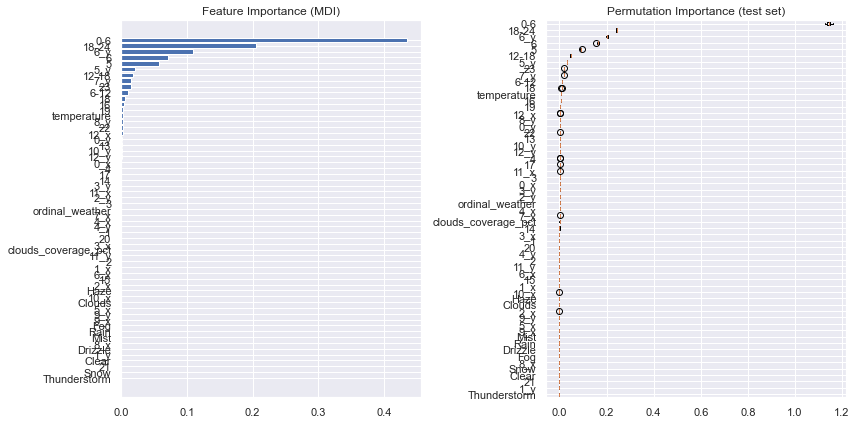

In [78]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

y_reg = reg.predict(x_train)

print(f'MAPE: {round(mean_absolute_percentage_error(y_train, y_reg) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(y_train, y_reg)}')
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(x_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, x_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(x_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

0.08168717384098441
67.22208806778993


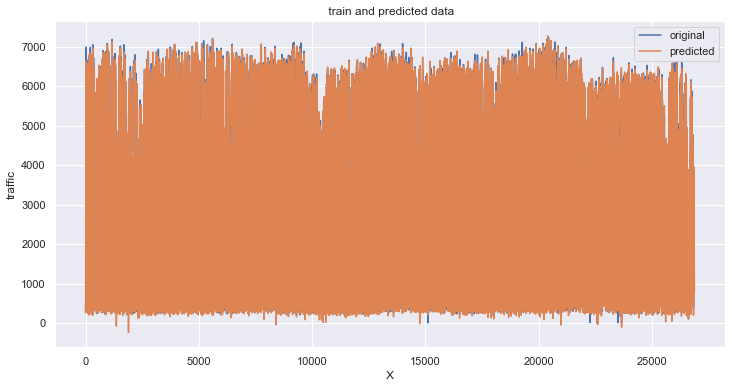

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

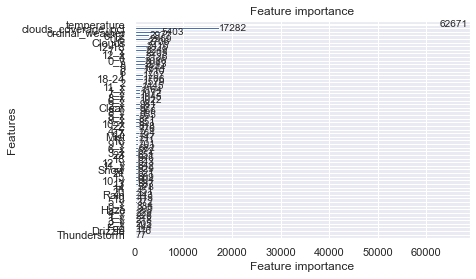

In [146]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'n_estimators': 900,
    'learning_rate': 0.3,
    'objective': 'regression',
    'num_leaves': 4096,
    'max_depth' : 12,
    'metric': {'l2','l1'},
    'verbose': -1
}

lgb_train = lgb.Dataset(x_train, y_train)


model = lgb.train(params,
                 train_set=lgb_train)
                 #valid_sets=y_train,
                 #early_stopping_rounds=30)


lgm_pred = model.predict(x_train)


print(mean_absolute_percentage_error(y_train, lgm_pred))
print(mean_absolute_error(y_train, lgm_pred))

x_ax = range(len(y_train))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_train, label="original")
plt.plot(x_ax, lgm_pred, label="predicted")
plt.title(" train and predicted data")
plt.xlabel('X')
plt.ylabel('traffic')
plt.legend(loc='best',fancybox=True, shadow=False)
plt.grid(True)
plt.show()  

lgb.plot_importance(model, height=.5)


0.08168717384098441
67.22208806778993


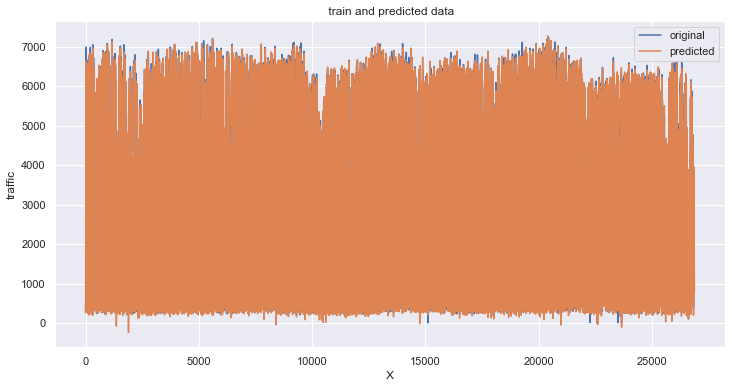

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

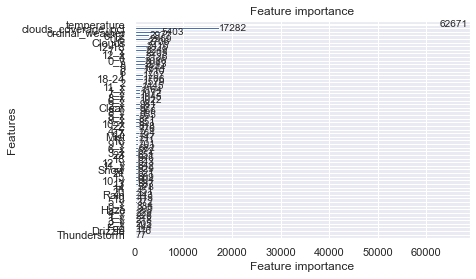

In [145]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'n_estimators': 900,
    'learning_rate': 0.3,
    'objective': 'regression',
    'num_leaves': 4096,
    'max_depth' : 12,
    'metric': {'l2','l1'},
    'verbose': -1
}

lgb_train = lgb.Dataset(x_train, y_train)


model = lgb.train(params,
                 train_set=lgb_train)
                 #valid_sets=y_train,
                 #early_stopping_rounds=30)


lgm_pred = model.predict(x_train)


print(mean_absolute_percentage_error(y_train, lgm_pred))
print(mean_absolute_error(y_train, lgm_pred))

x_ax = range(len(y_train))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_train, label="original")
plt.plot(x_ax, lgm_pred, label="predicted")
plt.title(" train and predicted data")
plt.xlabel('X')
plt.ylabel('traffic')
plt.legend(loc='best',fancybox=True, shadow=False)
plt.grid(True)
plt.show()  

lgb.plot_importance(model, height=.5)

In [99]:
cv_results = lgb.cv(
        params,
        lgb_train,
        nfold=5,
        num_boost_round=700,
        metrics='mape',
        stratified=False,
        verbose_eval=10, 
        early_stopping_rounds=40)


[10]	cv_agg's mape: 0.529834 + 0.210759
[20]	cv_agg's mape: 0.493953 + 0.218295
[30]	cv_agg's mape: 0.495265 + 0.220938
[40]	cv_agg's mape: 0.496784 + 0.222401
[50]	cv_agg's mape: 0.498013 + 0.222079


In [147]:
import sklearn
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(traffic.loc[:,traffic.columns!='traffic'], traffic.traffic, test_size=0.15)
    dtrain = lgb.Dataset(train_x, label=train_y)
 
    param = {
        'objective': 'regression',
        'metric': {'l2','l1'},
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 4096),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'task': 'train', 
        'boosting': 'gbdt',
        'verbose': -1
    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test_x)
    mape = sklearn.metrics.mean_absolute_percentage_error(test_y, preds)
    return mape
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-05-20 14:45:28,523] A new study created in memory with name: no-name-73330115-88fe-44a7-9205-dcfb82faf6de
[I 2022-05-20 14:45:28,537] A new study created in memory with name: no-name-0b2b0de7-2572-40b4-a5ac-3bb279b46ceb
[W 2022-05-20 14:45:28,539] Trial 0 failed because of the following error: ValueError('`valid_sets` is required.')
Traceback (most recent call last):
  File "E:\Anaconda\envs\ML\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\robso\AppData\Local\Temp\ipykernel_4056\1132102988.py", line 19, in objective
    gbm = lgb.train(param, dtrain)
  File "E:\Anaconda\envs\ML\lib\site-packages\optuna\integration\_lightgbm_tuner\__init__.py", line 34, in train
    auto_booster = LightGBMTuner(*args, **kwargs)
  File "E:\Anaconda\envs\ML\lib\site-packages\optuna\integration\_lightgbm_tuner\optimize.py", line 862, in __init__
    raise ValueError("`valid_sets` is required.")
ValueError: `valid_sets` is re

ValueError: `valid_sets` is required.

0.49752819231965295
297.4285274886593


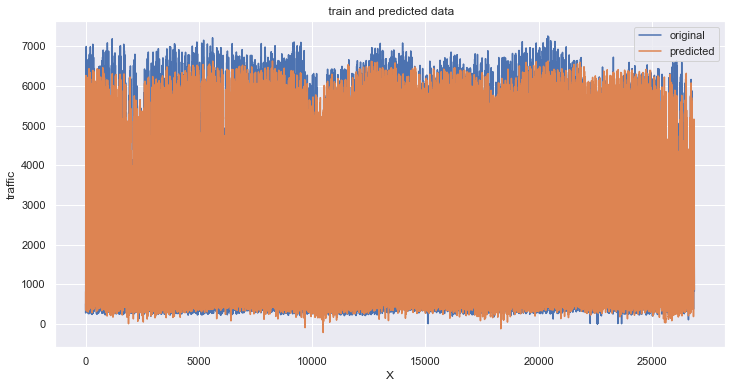

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

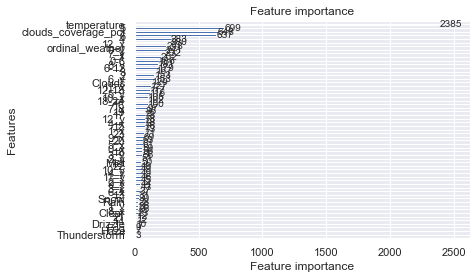

In [144]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'n_estimators': 654,
    'learning_rate': 0.04838946720385812,
    'objective': 'regression',
    'num_leaves': 2114,
    'max_depth' : 4,
    'metric': {'l2','l1'},
    'verbose': -1
}

lgb_train = lgb.Dataset(x_train, y_train)


model = lgb.train(params,
                 train_set=lgb_train)
                 #valid_sets=y_train,
                 #early_stopping_rounds=30)


lgm_pred = model.predict(x_train)


print(mean_absolute_percentage_error(y_train, lgm_pred))
print(mean_absolute_error(y_train, lgm_pred))

x_ax = range(len(y_train))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_train, label="original")
plt.plot(x_ax, lgm_pred, label="predicted")
plt.title(" train and predicted data")
plt.xlabel('X')
plt.ylabel('traffic')
plt.legend(loc='best',fancybox=True, shadow=False)
plt.grid(True)
plt.show()  

lgb.plot_importance(model, height=.5)

In [163]:
import numpy as np
import optuna.integration.lightgbm as lgb

from lightgbm import early_stopping
from lightgbm import log_evaluation
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(traffic.loc[:,traffic.columns!='traffic'], traffic.traffic, test_size=0.15)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(test_x, label=test_y)

params = {
'task': 'train', 
'boosting': 'gbdt',
'n_estimators': 900,
'learning_rate': 0.3,
'objective': 'regression',
'num_leaves': 4096,
'max_depth' : 12,
'metric': {'l2','l1'},
'verbose': -1
}

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    #callbacks=[early_stopping(100), log_evaluation(100)],
)

prediction = model.predict(val_x, num_iteration=model.best_iteration)
mape = mean_absolute_percentage_error(val_y, prediction)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(mape))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[I 2022-05-20 15:02:26,513] A new study created in memory with name: no-name-7f5108c7-b28e-4084-b526-59ff129c731c





  0%|                                                                                            | 0/7 [00:00<?, ?it/s]




feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[1]	valid_0's l2: 2.0755e+06	valid_0's l1: 1257.75	valid_1's l2: 2.07321e+06	valid_1's l1: 1260.33
[2]	valid_0's l2: 1.24567e+06	valid_0's l1: 966.868	valid_1's l2: 1.25787e+06	valid_1's l1: 974.785
[3]	valid_0's l2: 736358	valid_0's l1: 731.404	valid_1's l2: 753092	valid_1's l1: 741.893
[4]	valid_0's l2: 493128	valid_0's l1: 584.347	valid_1's l2: 511301	valid_1's l1: 596.432
[5]	valid_0's l2: 361979	valid_0's l1: 479.876	valid_1's l2: 380894	valid_1's l1: 493.504
[6]	valid_0's l2: 284802	valid_0's l1: 403.875	valid_1's l2: 305511	valid_1's l1: 419.673
[7]	valid_0's l2: 237959	valid_0's l1: 349.746	valid_1's l2: 262743	valid_1's l1: 369.521
[8]	valid_0's l2: 216177	valid_0's l1: 317.7	valid_1's l2: 243676	valid_1's l1: 339.952
[9]	valid_0's l2: 202187	valid_0's l1: 293.948	valid_1's l2: 232282	valid_1's l1: 318.691
[10]	valid_0's l2: 189947	valid_0's l1: 275.065	valid_1's l2: 223392	valid_1's l1: 302.987
[11]	valid_0's l2: 181962	valid_0's l1: 262.832	valid_1's l2: 218456	valid_1's l1:

[117]	valid_0's l2: 83675.4	valid_0's l1: 179.802	valid_1's l2: 190929	valid_1's l1: 273.618
[118]	valid_0's l2: 83445.9	valid_0's l1: 179.6	valid_1's l2: 191021	valid_1's l1: 273.522
[119]	valid_0's l2: 83256.9	valid_0's l1: 179.377	valid_1's l2: 191055	valid_1's l1: 273.416
[120]	valid_0's l2: 82930.6	valid_0's l1: 179.097	valid_1's l2: 191301	valid_1's l1: 273.685
[121]	valid_0's l2: 82808.3	valid_0's l1: 178.985	valid_1's l2: 191332	valid_1's l1: 273.671
[122]	valid_0's l2: 82489	valid_0's l1: 178.686	valid_1's l2: 191222	valid_1's l1: 273.662
[123]	valid_0's l2: 82064	valid_0's l1: 178.319	valid_1's l2: 191146	valid_1's l1: 273.656
[124]	valid_0's l2: 81805	valid_0's l1: 177.996	valid_1's l2: 191137	valid_1's l1: 273.662
[125]	valid_0's l2: 81476.2	valid_0's l1: 177.749	valid_1's l2: 190657	valid_1's l1: 273.651
[126]	valid_0's l2: 81260.7	valid_0's l1: 177.52	valid_1's l2: 190630	valid_1's l1: 273.809
[127]	valid_0's l2: 80973.4	valid_0's l1: 177.207	valid_1's l2: 190669	valid_1'

[220]	valid_0's l2: 59348.2	valid_0's l1: 153.266	valid_1's l2: 193324	valid_1's l1: 278.698
[221]	valid_0's l2: 59227.9	valid_0's l1: 153.099	valid_1's l2: 193327	valid_1's l1: 278.707
[222]	valid_0's l2: 59075.4	valid_0's l1: 152.92	valid_1's l2: 193355	valid_1's l1: 278.785
[223]	valid_0's l2: 58894.7	valid_0's l1: 152.669	valid_1's l2: 193485	valid_1's l1: 278.92
[224]	valid_0's l2: 58776.8	valid_0's l1: 152.482	valid_1's l2: 193361	valid_1's l1: 278.811
[225]	valid_0's l2: 58675.6	valid_0's l1: 152.325	valid_1's l2: 193430	valid_1's l1: 278.895
[226]	valid_0's l2: 58585.5	valid_0's l1: 152.218	valid_1's l2: 193472	valid_1's l1: 278.955
[227]	valid_0's l2: 58376.6	valid_0's l1: 151.902	valid_1's l2: 193344	valid_1's l1: 278.844
[228]	valid_0's l2: 58114.7	valid_0's l1: 151.585	valid_1's l2: 193420	valid_1's l1: 278.912
[229]	valid_0's l2: 58026.3	valid_0's l1: 151.459	valid_1's l2: 193444	valid_1's l1: 278.926
[230]	valid_0's l2: 57796.5	valid_0's l1: 151.197	valid_1's l2: 193578	v

[312]	valid_0's l2: 46583.6	valid_0's l1: 136.767	valid_1's l2: 197096	valid_1's l1: 281.075
[313]	valid_0's l2: 46404.7	valid_0's l1: 136.523	valid_1's l2: 197051	valid_1's l1: 281.102
[314]	valid_0's l2: 46143.6	valid_0's l1: 136.159	valid_1's l2: 197188	valid_1's l1: 281.34
[315]	valid_0's l2: 46025.9	valid_0's l1: 136.005	valid_1's l2: 197205	valid_1's l1: 281.341
[316]	valid_0's l2: 45985.4	valid_0's l1: 135.907	valid_1's l2: 197217	valid_1's l1: 281.386
[317]	valid_0's l2: 45850	valid_0's l1: 135.715	valid_1's l2: 197203	valid_1's l1: 281.365
[318]	valid_0's l2: 45775.9	valid_0's l1: 135.582	valid_1's l2: 197232	valid_1's l1: 281.376
[319]	valid_0's l2: 45692.5	valid_0's l1: 135.445	valid_1's l2: 197336	valid_1's l1: 281.422
[320]	valid_0's l2: 45633.8	valid_0's l1: 135.375	valid_1's l2: 197312	valid_1's l1: 281.447
[321]	valid_0's l2: 45606.3	valid_0's l1: 135.33	valid_1's l2: 197346	valid_1's l1: 281.487
[322]	valid_0's l2: 45416.5	valid_0's l1: 135.03	valid_1's l2: 197270	vali

[412]	valid_0's l2: 38309.9	valid_0's l1: 124.398	valid_1's l2: 199851	valid_1's l1: 284.09
[413]	valid_0's l2: 38230.1	valid_0's l1: 124.264	valid_1's l2: 199912	valid_1's l1: 284.146
[414]	valid_0's l2: 38115.2	valid_0's l1: 124.06	valid_1's l2: 199986	valid_1's l1: 284.166
[415]	valid_0's l2: 38066.2	valid_0's l1: 123.962	valid_1's l2: 199988	valid_1's l1: 284.2
[416]	valid_0's l2: 38029.9	valid_0's l1: 123.895	valid_1's l2: 199997	valid_1's l1: 284.261
[417]	valid_0's l2: 38015.3	valid_0's l1: 123.864	valid_1's l2: 200049	valid_1's l1: 284.289
[418]	valid_0's l2: 37920.9	valid_0's l1: 123.757	valid_1's l2: 200094	valid_1's l1: 284.345
[419]	valid_0's l2: 37894.6	valid_0's l1: 123.713	valid_1's l2: 200170	valid_1's l1: 284.391
[420]	valid_0's l2: 37852.6	valid_0's l1: 123.649	valid_1's l2: 200167	valid_1's l1: 284.35
[421]	valid_0's l2: 37762.1	valid_0's l1: 123.486	valid_1's l2: 200123	valid_1's l1: 284.376
[422]	valid_0's l2: 37664.6	valid_0's l1: 123.344	valid_1's l2: 200092	vali

[506]	valid_0's l2: 32041.2	valid_0's l1: 113.453	valid_1's l2: 203619	valid_1's l1: 287.927
[507]	valid_0's l2: 31952.3	valid_0's l1: 113.303	valid_1's l2: 203590	valid_1's l1: 287.815
[508]	valid_0's l2: 31911.4	valid_0's l1: 113.215	valid_1's l2: 203614	valid_1's l1: 287.859
[509]	valid_0's l2: 31839	valid_0's l1: 113.116	valid_1's l2: 203586	valid_1's l1: 287.935
[510]	valid_0's l2: 31804.5	valid_0's l1: 113.041	valid_1's l2: 203572	valid_1's l1: 287.864
[511]	valid_0's l2: 31726.1	valid_0's l1: 112.877	valid_1's l2: 203680	valid_1's l1: 287.876
[512]	valid_0's l2: 31640.7	valid_0's l1: 112.764	valid_1's l2: 203589	valid_1's l1: 287.88
[513]	valid_0's l2: 31586.2	valid_0's l1: 112.661	valid_1's l2: 203617	valid_1's l1: 287.911
[514]	valid_0's l2: 31527.7	valid_0's l1: 112.585	valid_1's l2: 203690	valid_1's l1: 287.925
[515]	valid_0's l2: 31468.5	valid_0's l1: 112.456	valid_1's l2: 203754	valid_1's l1: 287.987
[516]	valid_0's l2: 31444	valid_0's l1: 112.407	valid_1's l2: 203766	vali

[599]	valid_0's l2: 27528.2	valid_0's l1: 105.041	valid_1's l2: 206076	valid_1's l1: 289.336
[600]	valid_0's l2: 27475.5	valid_0's l1: 104.941	valid_1's l2: 206128	valid_1's l1: 289.385
[601]	valid_0's l2: 27393.7	valid_0's l1: 104.827	valid_1's l2: 206316	valid_1's l1: 289.52
[602]	valid_0's l2: 27342.9	valid_0's l1: 104.732	valid_1's l2: 206330	valid_1's l1: 289.513
[603]	valid_0's l2: 27315.8	valid_0's l1: 104.677	valid_1's l2: 206371	valid_1's l1: 289.553
[604]	valid_0's l2: 27256.9	valid_0's l1: 104.544	valid_1's l2: 206365	valid_1's l1: 289.532
[605]	valid_0's l2: 27228.7	valid_0's l1: 104.478	valid_1's l2: 206505	valid_1's l1: 289.627
[606]	valid_0's l2: 27198.3	valid_0's l1: 104.4	valid_1's l2: 206574	valid_1's l1: 289.652
[607]	valid_0's l2: 27077.6	valid_0's l1: 104.109	valid_1's l2: 206620	valid_1's l1: 289.744
[608]	valid_0's l2: 26980.1	valid_0's l1: 103.895	valid_1's l2: 206650	valid_1's l1: 289.706
[609]	valid_0's l2: 26926.8	valid_0's l1: 103.784	valid_1's l2: 206695	va

[688]	valid_0's l2: 23478.4	valid_0's l1: 96.7103	valid_1's l2: 209132	valid_1's l1: 291.467
[689]	valid_0's l2: 23453.4	valid_0's l1: 96.6739	valid_1's l2: 209144	valid_1's l1: 291.476
[690]	valid_0's l2: 23433.8	valid_0's l1: 96.6358	valid_1's l2: 209173	valid_1's l1: 291.531
[691]	valid_0's l2: 23421.3	valid_0's l1: 96.5977	valid_1's l2: 209186	valid_1's l1: 291.554
[692]	valid_0's l2: 23402.1	valid_0's l1: 96.5497	valid_1's l2: 209258	valid_1's l1: 291.603
[693]	valid_0's l2: 23375	valid_0's l1: 96.5214	valid_1's l2: 209288	valid_1's l1: 291.635
[694]	valid_0's l2: 23342.2	valid_0's l1: 96.4214	valid_1's l2: 209323	valid_1's l1: 291.637
[695]	valid_0's l2: 23310.3	valid_0's l1: 96.3465	valid_1's l2: 209374	valid_1's l1: 291.681
[696]	valid_0's l2: 23256.1	valid_0's l1: 96.2289	valid_1's l2: 209426	valid_1's l1: 291.8
[697]	valid_0's l2: 23237.6	valid_0's l1: 96.2144	valid_1's l2: 209433	valid_1's l1: 291.812
[698]	valid_0's l2: 23211.4	valid_0's l1: 96.164	valid_1's l2: 209434	vali

[789]	valid_0's l2: 20763.4	valid_0's l1: 90.6502	valid_1's l2: 211712	valid_1's l1: 293.739
[790]	valid_0's l2: 20750.3	valid_0's l1: 90.6107	valid_1's l2: 211740	valid_1's l1: 293.742
[791]	valid_0's l2: 20725	valid_0's l1: 90.5594	valid_1's l2: 211716	valid_1's l1: 293.735
[792]	valid_0's l2: 20680.1	valid_0's l1: 90.4893	valid_1's l2: 211678	valid_1's l1: 293.727
[793]	valid_0's l2: 20668	valid_0's l1: 90.4616	valid_1's l2: 211690	valid_1's l1: 293.757
[794]	valid_0's l2: 20642.2	valid_0's l1: 90.4135	valid_1's l2: 211760	valid_1's l1: 293.828
[795]	valid_0's l2: 20590	valid_0's l1: 90.3017	valid_1's l2: 211785	valid_1's l1: 293.8
[796]	valid_0's l2: 20511.4	valid_0's l1: 90.147	valid_1's l2: 211857	valid_1's l1: 293.848
[797]	valid_0's l2: 20498.3	valid_0's l1: 90.1155	valid_1's l2: 211952	valid_1's l1: 293.905
[798]	valid_0's l2: 20491.1	valid_0's l1: 90.0921	valid_1's l2: 211948	valid_1's l1: 293.898
[799]	valid_0's l2: 20449.9	valid_0's l1: 89.988	valid_1's l2: 211988	valid_1's

[894]	valid_0's l2: 18191.8	valid_0's l1: 84.5545	valid_1's l2: 213965	valid_1's l1: 295.551
[895]	valid_0's l2: 18175	valid_0's l1: 84.5027	valid_1's l2: 213973	valid_1's l1: 295.557
[896]	valid_0's l2: 18145.3	valid_0's l1: 84.4507	valid_1's l2: 214041	valid_1's l1: 295.613
[897]	valid_0's l2: 18126.1	valid_0's l1: 84.4011	valid_1's l2: 214057	valid_1's l1: 295.627
[898]	valid_0's l2: 18119.9	valid_0's l1: 84.3849	valid_1's l2: 214030	valid_1's l1: 295.62
[899]	valid_0's l2: 18104	valid_0's l1: 84.3497	valid_1's l2: 213998	valid_1's l1: 295.609
[900]	valid_0's l2: 18100.2	valid_0's l1: 84.3403	valid_1's l2: 213998	valid_1's l1: 295.609







feature_fraction, val_score: 295.609388:   0%|                                                   | 0/7 [00:05<?, ?it/s]




feature_fraction, val_score: 295.609388:  14%|######1                                    | 1/7 [00:05<00:33,  5.62s/it][W 2022-05-20 15:02:32,136] Trial 0 failed because of the following error: TypeError('Object of type set is not JSON serializable')
Traceback (most recent call last):
  File "E:\Anaconda\envs\ML\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "E:\Anaconda\envs\ML\lib\site-packages\optuna\integration\_lightgbm_tuner\optimize.py", line 265, in __call__
    self._postprocess(trial, elapsed_secs, average_iteration_time)
  File "E:\Anaconda\envs\ML\lib\site-packages\optuna\integration\_lightgbm_tuner\optimize.py", line 279, in _postprocess
    trial.set_system_attr(_LGBM_PARAMS_KEY, json.dumps(self.lgbm_params))
  File "E:\Anaconda\envs\ML\lib\json\__init__.py", line 231, in dumps
    

TypeError: Object of type set is not JSON serializable

,clouds_coverage_pct,temperature,ordinal_weather,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,0-6,6-12,12-18,18-24,0_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13,14,15,16,17,18,19,20,21,22,23,0_y,1,2,3,4,5,6,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Snow,Thunderstorm
2834,90,1.7,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
622,90,6.9,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
13733,90,1.3,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2542,40,-8.6,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
20748,90,-6.3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,90,-1.4,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
17727,1,23.2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
12451,1,-11.4,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
17938,1,22.4,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
